# Neighborhood Analysis

To find structures within our tissues, we can use the concept of cellular neighborhoods. The idea is that we start by defining neighborhoods for each cell, which consist of the relative abundances of the surrounding cell types. Afterwards, we can use clustering across multiple samples to define the neighborhoods. Finally, we can add these neighborhood labels back into the `spatialproteomics` object and use them to select specific regions of the tissue. Methods relating to neighborhoods are contained in the `nh` module. For convenience, you can use the `sp.ImageContainer` to perform this analysis with a single function call.

If you want to follow along with this tutorial, you can download the data [here](https://oc.embl.de/index.php/s/XzEa9po1tjiDzzJ).

In [1]:
%reload_ext autoreload
%autoreload 2

import spatialproteomics as sp
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns

## Neighborhood Analysis with the ImageContainer

As a first step, we open three datasets and store them inside of a dictionary.

In [2]:
sp_obj_1 = xr.open_zarr("../../data/LN_24_1.zarr")
sp_obj_2 = xr.open_zarr("../../data/LN_11_1.zarr")
sp_obj_3 = xr.open_zarr("../../data/LN_13_1.zarr")

# === OPTIONAL ===
# setting the label level to the top level, so that we only consider major cell types (B, T, etc.)
# this is done for demonstration purposes, you can just as well compute the neighborhood on more fine-grained cell types
celltype_colors = {
    "B cell": "#5799d1",
    "T cell": "#ebc850",
    "Myeloid cell": "#de6866",
    "Dendritic cell": "#4cbcbd",
    "Macrophage": "#bb7cb4",
    "Stromal cell": "#62b346",
    "Endothelial cell": "#bf997d",
}

sp_obj_1 = (
    sp_obj_1.pp.drop_layers(["_neighborhoods", "_nh_properties", "_adjacency_matrix"])
    .la.set_label_level("labels_0")
    .la.set_label_colors(celltype_colors.keys(), celltype_colors.values())
)
sp_obj_2 = (
    sp_obj_2.pp.drop_layers(["_neighborhoods", "_nh_properties", "_adjacency_matrix"])
    .la.set_label_level("labels_0")
    .la.set_label_colors(celltype_colors.keys(), celltype_colors.values())
)
sp_obj_3 = (
    sp_obj_3.pp.drop_layers(["_neighborhoods", "_nh_properties", "_adjacency_matrix"])
    .la.set_label_level("labels_0")
    .la.set_label_colors(celltype_colors.keys(), celltype_colors.values())
)

Removing neighborhoods from observations. If you want to keep the neighborhoods in the obs layer, set drop_obs=False.
Removing neighborhoods from observations. If you want to keep the neighborhoods in the obs layer, set drop_obs=False.
Removing neighborhoods from observations. If you want to keep the neighborhoods in the obs layer, set drop_obs=False.


In [3]:
sp_dict = {"1": sp_obj_1, "2": sp_obj_2, "3": sp_obj_3}

Next, we put this dictionary into an `ImageContainer` and run the method `compute_neighborhoods()`. This will compute the neighborhoods for each object, and also run k-means clustering over all samples. If you want to do this yourself, please refer to the section at the end of this notebook.

In [4]:
image_container = sp.ImageContainer(sp_dict)
# this method returns a dict in the same format as we provided as input
sp_dict = image_container.compute_neighborhoods(k=3)

Let's plot the cell type labels and the resulting neighborhoods.

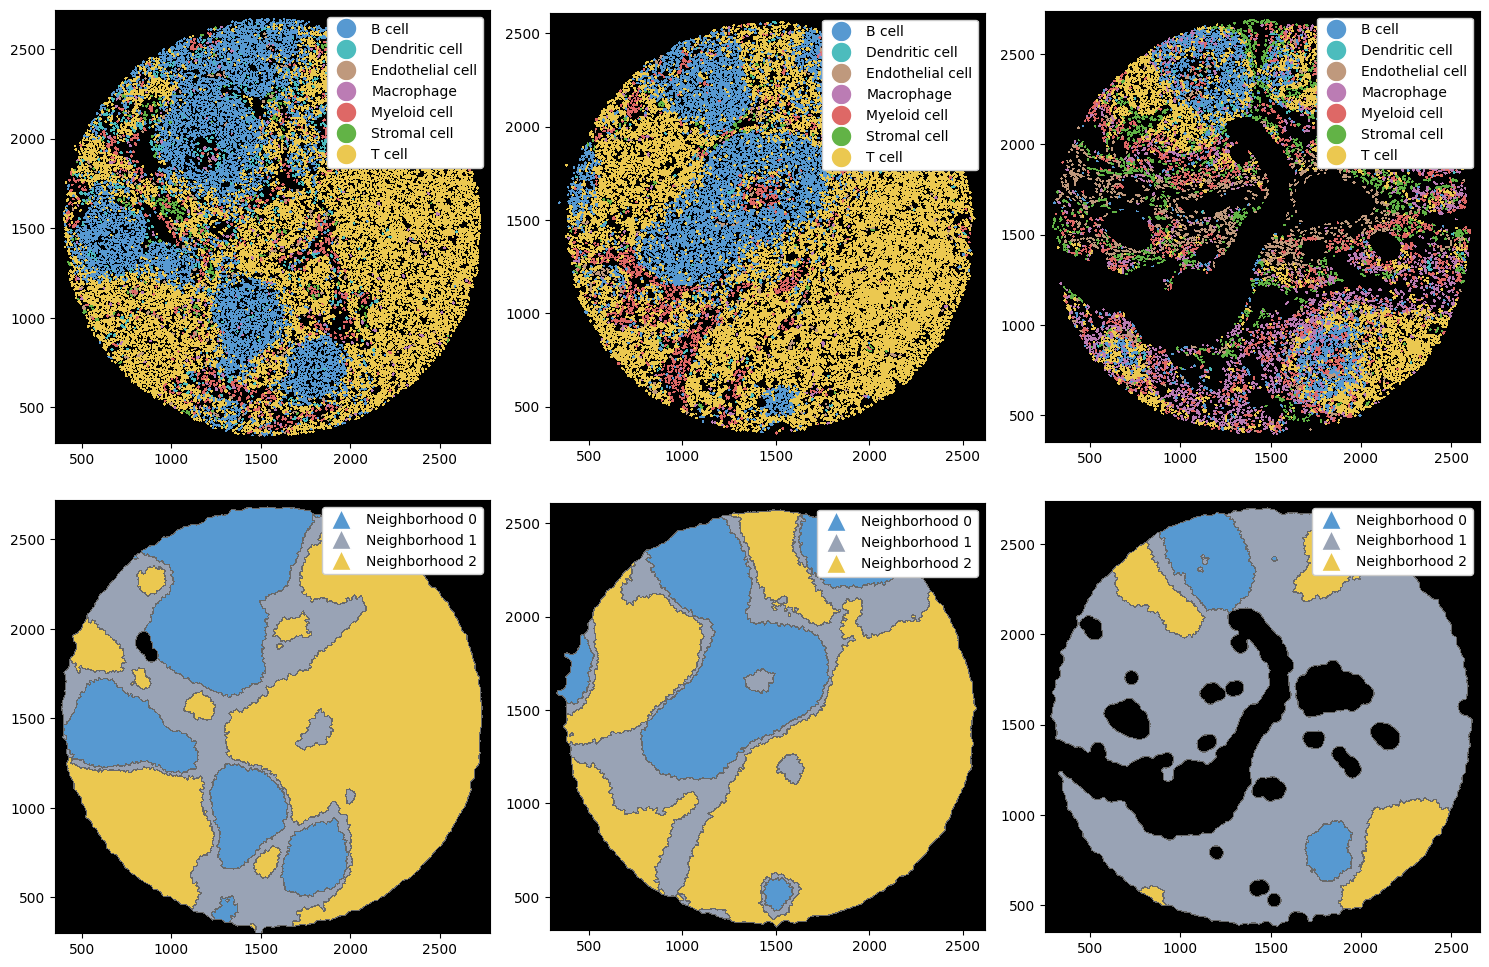

In [5]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.flatten()

# setting custom colors to be more in line with the cell types
neighborhoods, colors = [f"Neighborhood {x}" for x in np.arange(3)], ["#5799d1", "#99a3b5", "#ebc850"]

# plotting labels
_ = sp_dict["1"].pl.autocrop().pl.show(render_image=False, render_labels=True, ax=ax[0])
_ = sp_dict["2"].pl.autocrop().pl.show(render_image=False, render_labels=True, ax=ax[1])
_ = sp_dict["3"].pl.autocrop().pl.show(render_image=False, render_labels=True, ax=ax[2])

# plotting neighborhoods
_ = (
    sp_dict["1"]
    .pl.autocrop()
    .nh.set_neighborhood_colors(neighborhoods, colors)
    .pl.show(render_image=False, render_neighborhoods=True, ax=ax[3])
)
_ = (
    sp_dict["2"]
    .pl.autocrop()
    .nh.set_neighborhood_colors(neighborhoods, colors)
    .pl.show(render_image=False, render_neighborhoods=True, ax=ax[4])
)
_ = (
    sp_dict["3"]
    .pl.autocrop()
    .nh.set_neighborhood_colors(neighborhoods, colors)
    .pl.show(render_image=False, render_neighborhoods=True, ax=ax[5])
)

plt.tight_layout()

By using the function `get_neighborhood_composition()` from the image container, we can easily plot a heatmap showing the neighborhood composition. By default, this composition dataframe is standardized per cell type.

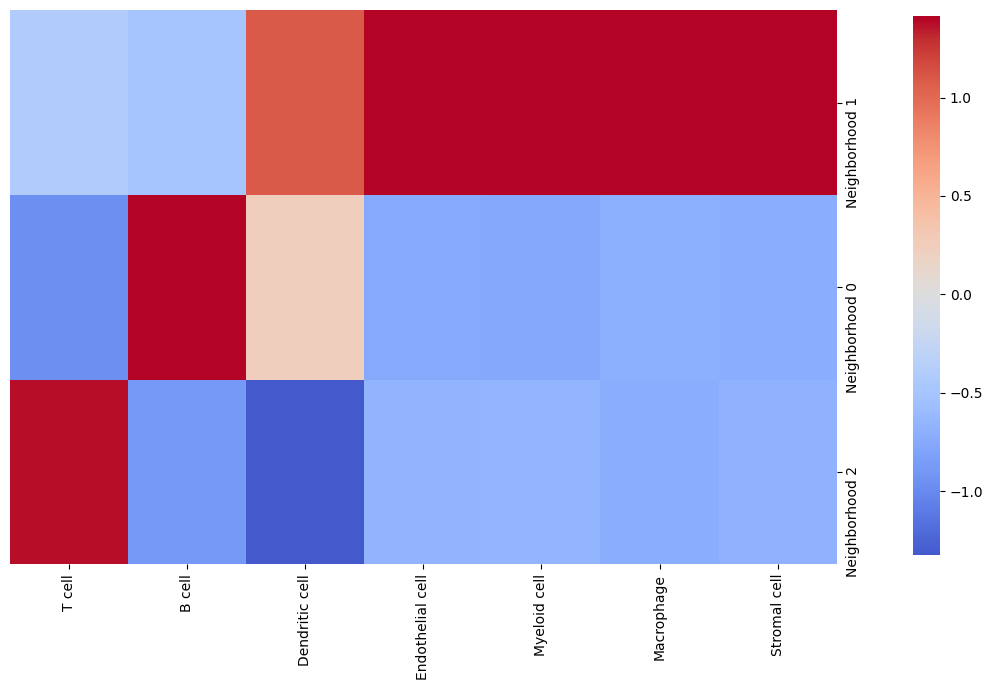

In [6]:
# obtaining a data frame containing the neighborhood compositions
nh_composition = image_container.get_neighborhood_composition()

# plotting the neighborhood composition as a seaborn clustermap
cluster_map = sns.clustermap(
    nh_composition,
    cmap="coolwarm",
    cbar_pos=(1.02, 0.2, 0.03, 0.77),  # Position the colorbar to the right of the heatmap
    dendrogram_ratio=(0.00001, 0),  # Remove row dendrogram
    figsize=(9, 7),  # Adjust the size
    annot=False,  # No annotation
    center=0,  # Setting the center of the colorbar to 0
)

# customizations of the plot
cluster_map.ax_heatmap.set_ylabel("")
plt.show()

We can also rename the neighborhoods for convenience.

In [7]:
neighborhood_names = {
    "Neighborhood 0": "B high",
    "Neighborhood 1": "Other",
    "Neighborhood 2": "T high",
}
sp_dict["1"] = sp_dict["1"].nh.set_neighborhood_name(neighborhood_names.keys(), neighborhood_names.values())

## Comparison of different neighborhood methods
There are three main ways how a neighborhood can be computed: via a radius, a k-nearest neighborh graph, or a Delaunay triangulation.
In the `radius` method, a circle with a certain radius is drawn around a cell, and the cell type frequencies are aggregated.
With `knn`, the k nearest neighbors of a cell are counted as the neighborhood.
Finally, `delaunay` creates a Delaunay triangulation from the cell centroids and counts cells as part of each other's neighborhood if they are connected in the resulting graph.

Let's look at how these three methods perform on the example data from above.
To illustrate the differences better, we also cluster with a higher k, resulting in more neighborhoods. 
Note that you could do all of this with the `ImageContainer` as well.

In [8]:
# putting the strategy from above into a single method
def compute_and_plot_clusters(sp_dict, k=5, method="radius"):
    # computing the neighborhoods
    image_container = sp.ImageContainer(sp_dict)
    sp_dict = image_container.compute_neighborhoods(neighborhood_method=method)

    # ===== PLOTTING =====
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    ax = ax.flatten()

    _ = sp_dict["1"].pl.autocrop().pl.show(render_image=False, render_neighborhoods=True, ax=ax[0])
    _ = sp_dict["2"].pl.autocrop().pl.show(render_image=False, render_neighborhoods=True, ax=ax[1])
    _ = sp_dict["3"].pl.autocrop().pl.show(render_image=False, render_neighborhoods=True, ax=ax[2])

    _ = sp_dict["1"].pl.autocrop().pl.show(render_image=False, render_labels=True, ax=ax[3])
    _ = sp_dict["2"].pl.autocrop().pl.show(render_image=False, render_labels=True, ax=ax[4])
    _ = sp_dict["3"].pl.autocrop().pl.show(render_image=False, render_labels=True, ax=ax[5])

    for axis in ax:
        axis.set_xticks([])
        axis.set_yticks([])
    plt.suptitle(method)
    plt.tight_layout()
    plt.show()

Note that the colors for the neighborhoods were chosen arbitrarily here.

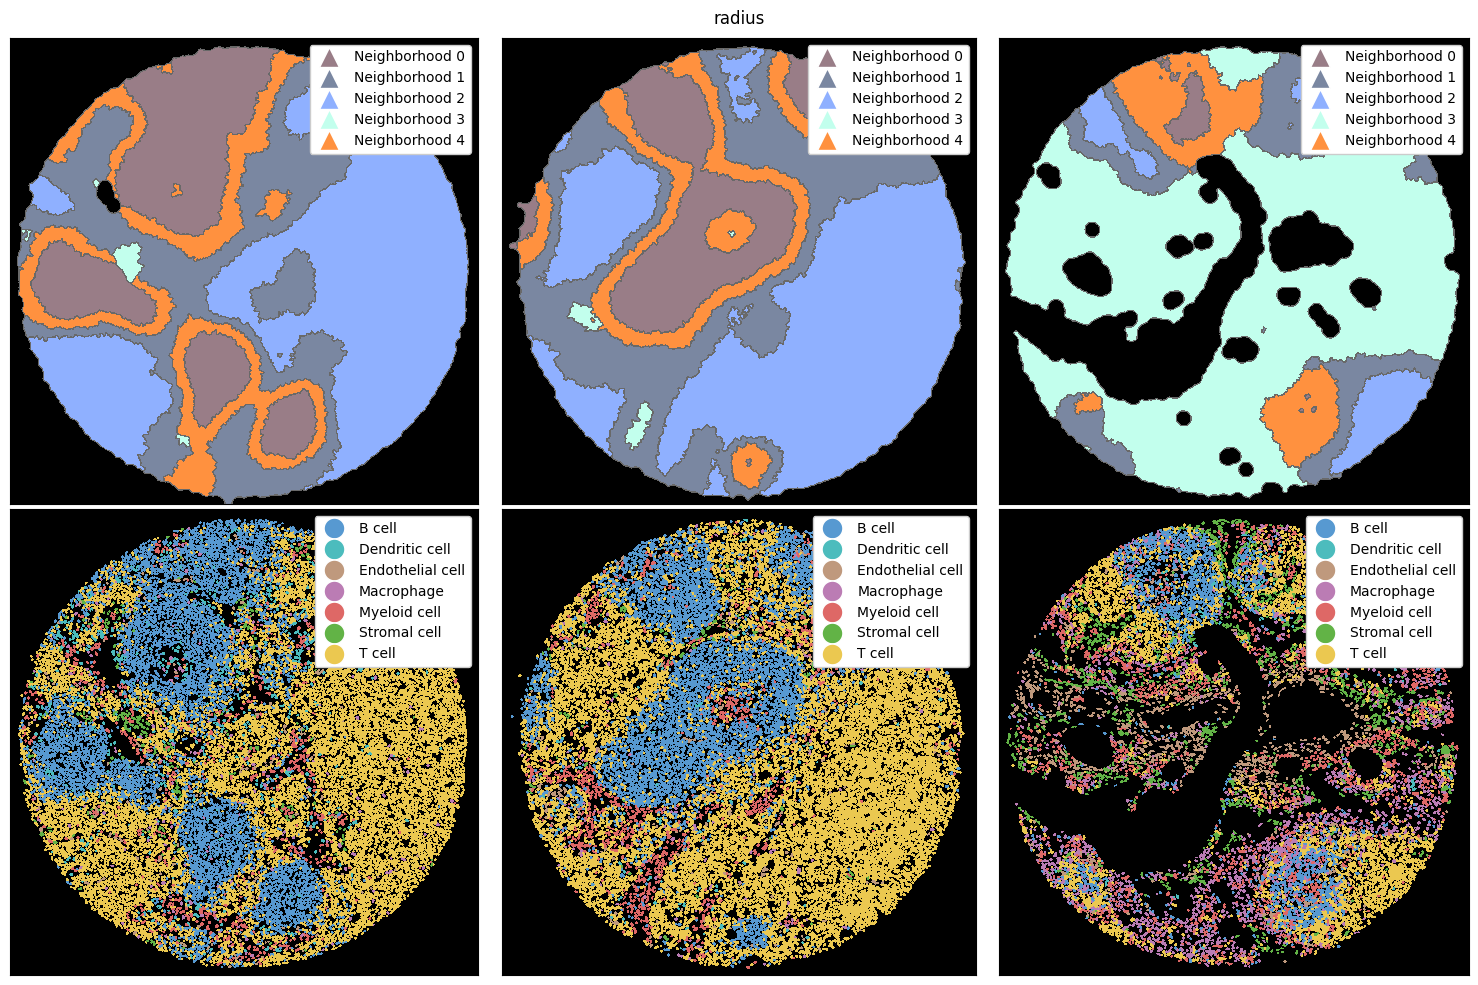

In [9]:
tmp_dict = {"1": sp_obj_1, "2": sp_obj_2, "3": sp_obj_3}
compute_and_plot_clusters(tmp_dict, k=5, method="radius")

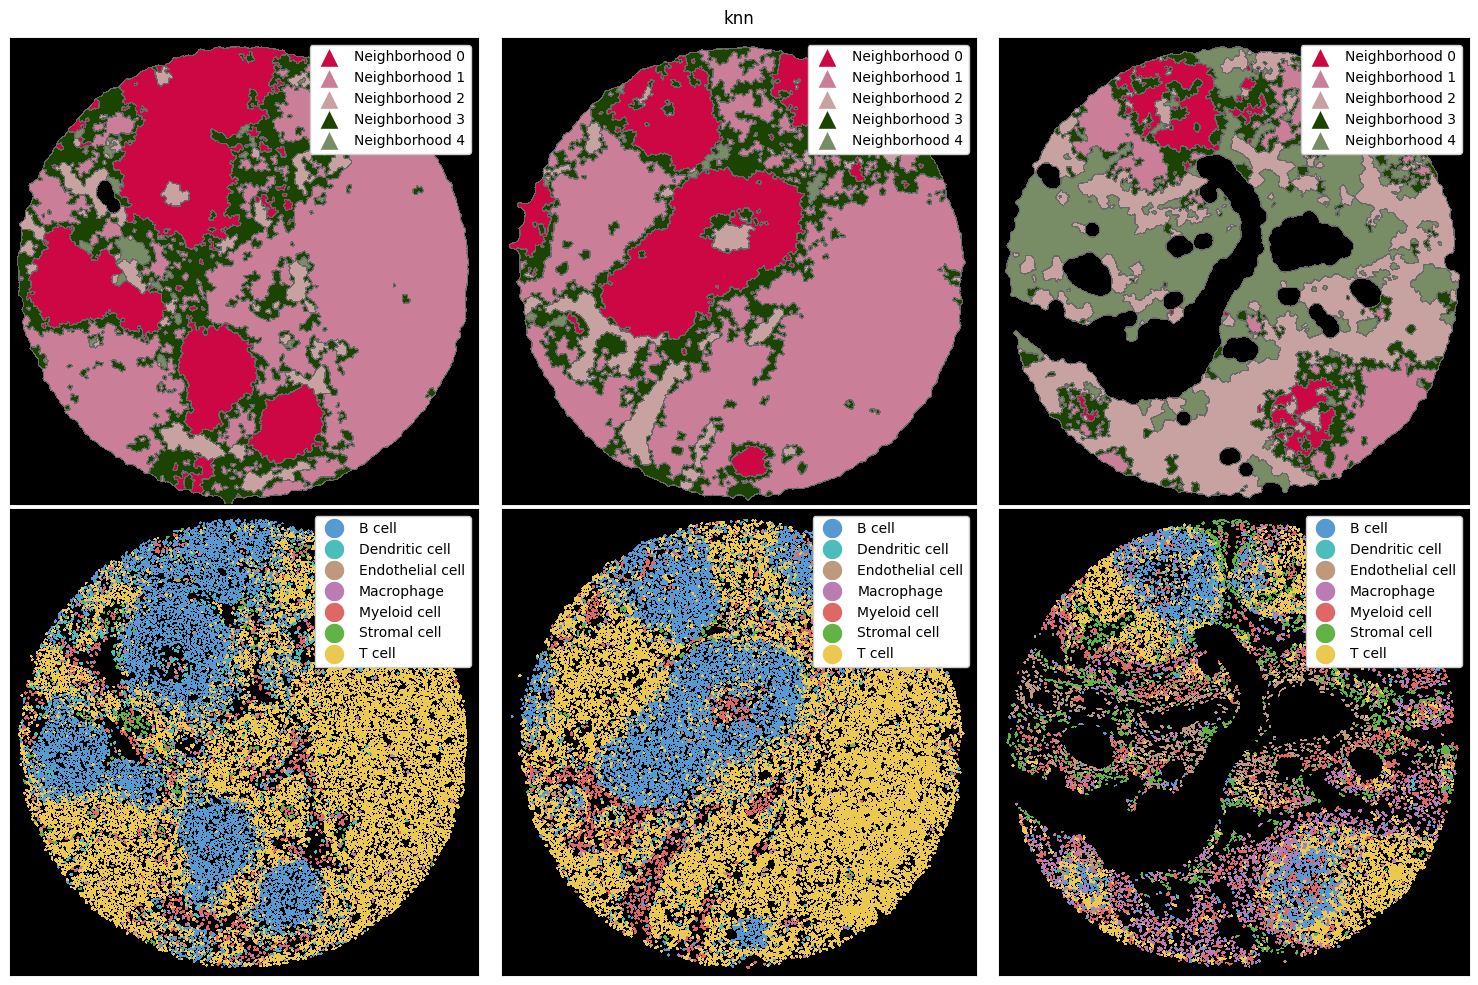

In [10]:
tmp_dict = {"1": sp_obj_1, "2": sp_obj_2, "3": sp_obj_3}
compute_and_plot_clusters(tmp_dict, k=5, method="knn")

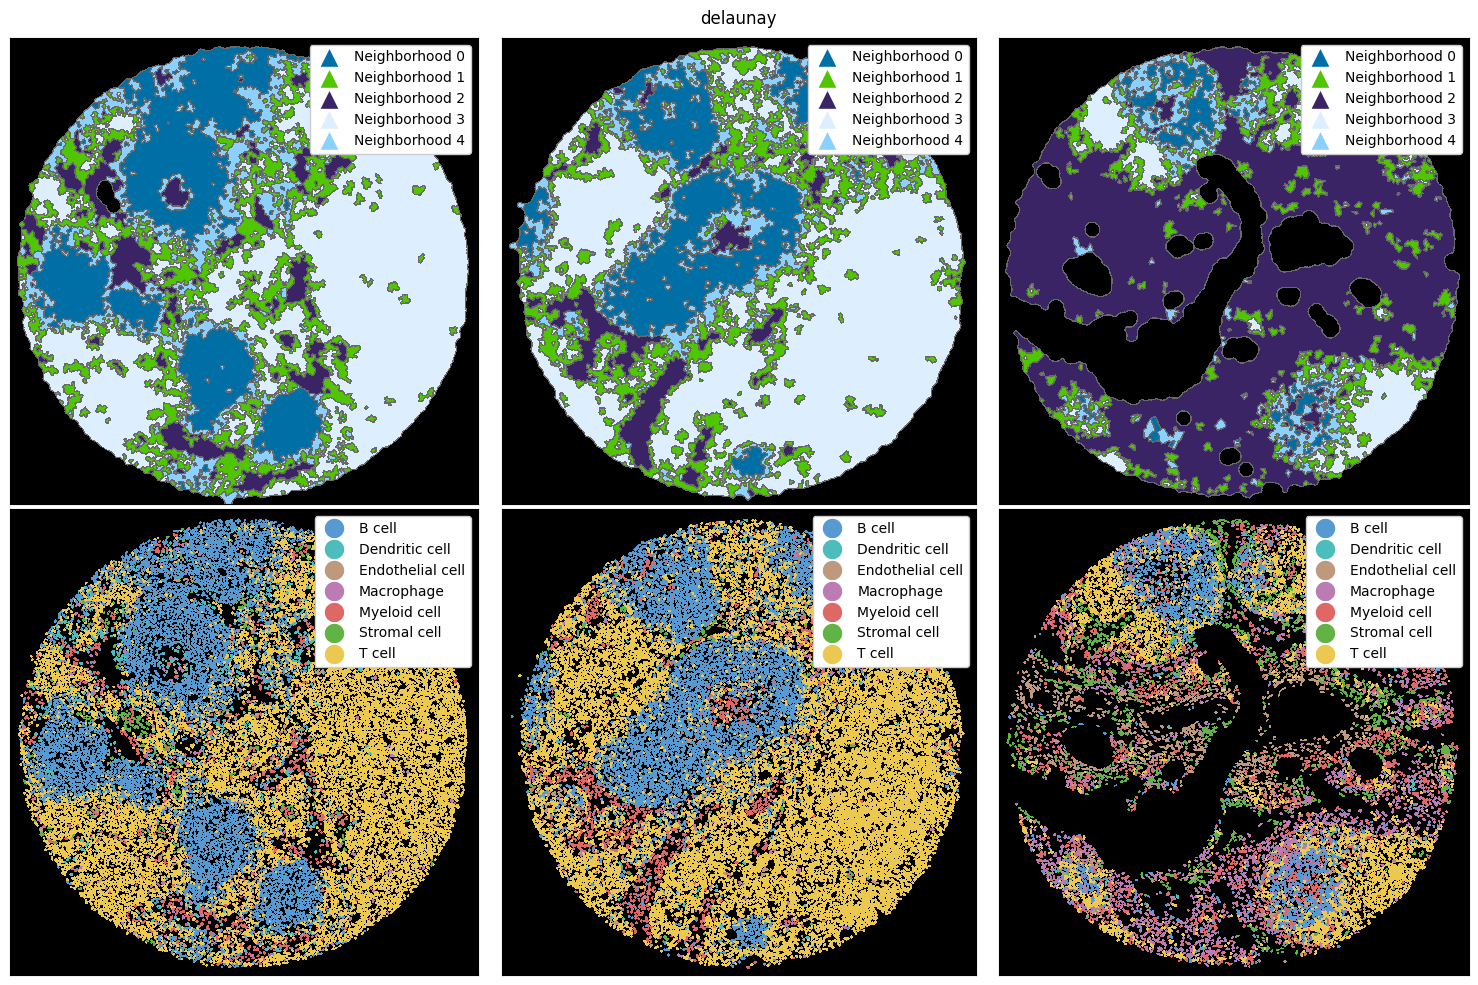

In [11]:
tmp_dict = {"1": sp_obj_1, "2": sp_obj_2, "3": sp_obj_3}
compute_and_plot_clusters(tmp_dict, k=5, method="delaunay")

As a small sidenote, let's quickly see how we can plot the network.

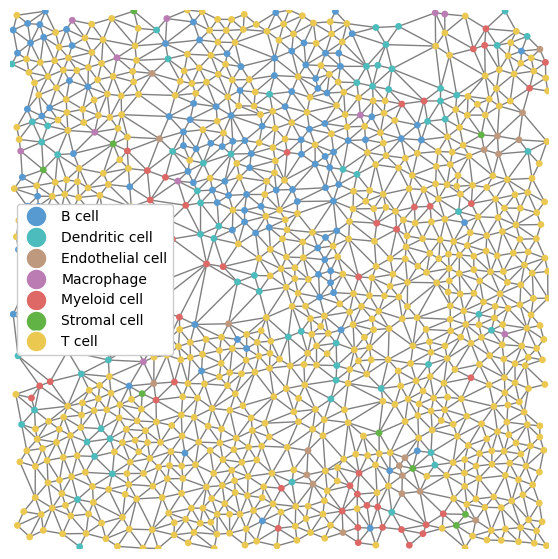

In [12]:
plt.figure(figsize=(7, 7))
_ = tmp_dict["1"].pp[1500:2000, 1500:2000].pl.scatter_labels(size=15, render_edges=True)

## Computing network features

Neighborhoods naturally lend themselves to being defined via networks. Each cell represents a node in the network, and two cells are connected if they are in the same neighborhood. For example, if we define neighborhoods with the distance-based `radius` method, we can connect two cells if their centroids are less than `radius` units apart. This means that we can now employ techniques from network analysis to further analyse structures within the tissue. This step can be performed simply by calling `ds.nh.add_neighborhood_obs()`. For more details on which features you can compute, refer to the documentation of the method.

Let's compute a couple of metrics. In the following codeblock, we compute:
1. Node degree: how many cells are connected to a cell. This can give you a hint about how dense the tissue is at any region (given you used the radius method for constructing your neighborhoods).
2. Homophily: ratio of cells of the same cell type as the center cell within the neighborhood.
3. Inter-Label Connectivity: ratio of cells of a different cell type as the center cell within the neighborhood.
4. Diversity Index: Shannon's entropy. Measures the diversity of cells within a cells neighborhood.

In [13]:
# setting label colors
ds = sp_dict["1"].nh.set_neighborhood_colors(["T high", "Other", "B high"], ["#ebc850", "#99a3b5", "#5799d1"])
# computing the neighborhood features
ds = ds.nh.add_neighborhood_obs(
    features=["degree", "homophily", "inter_label_connectivity", "diversity_index"]
).pl.autocrop()

Overwriting existing neighborhood observations: ['degree', 'diversity_index', 'homophily', 'inter_label_connectivity']


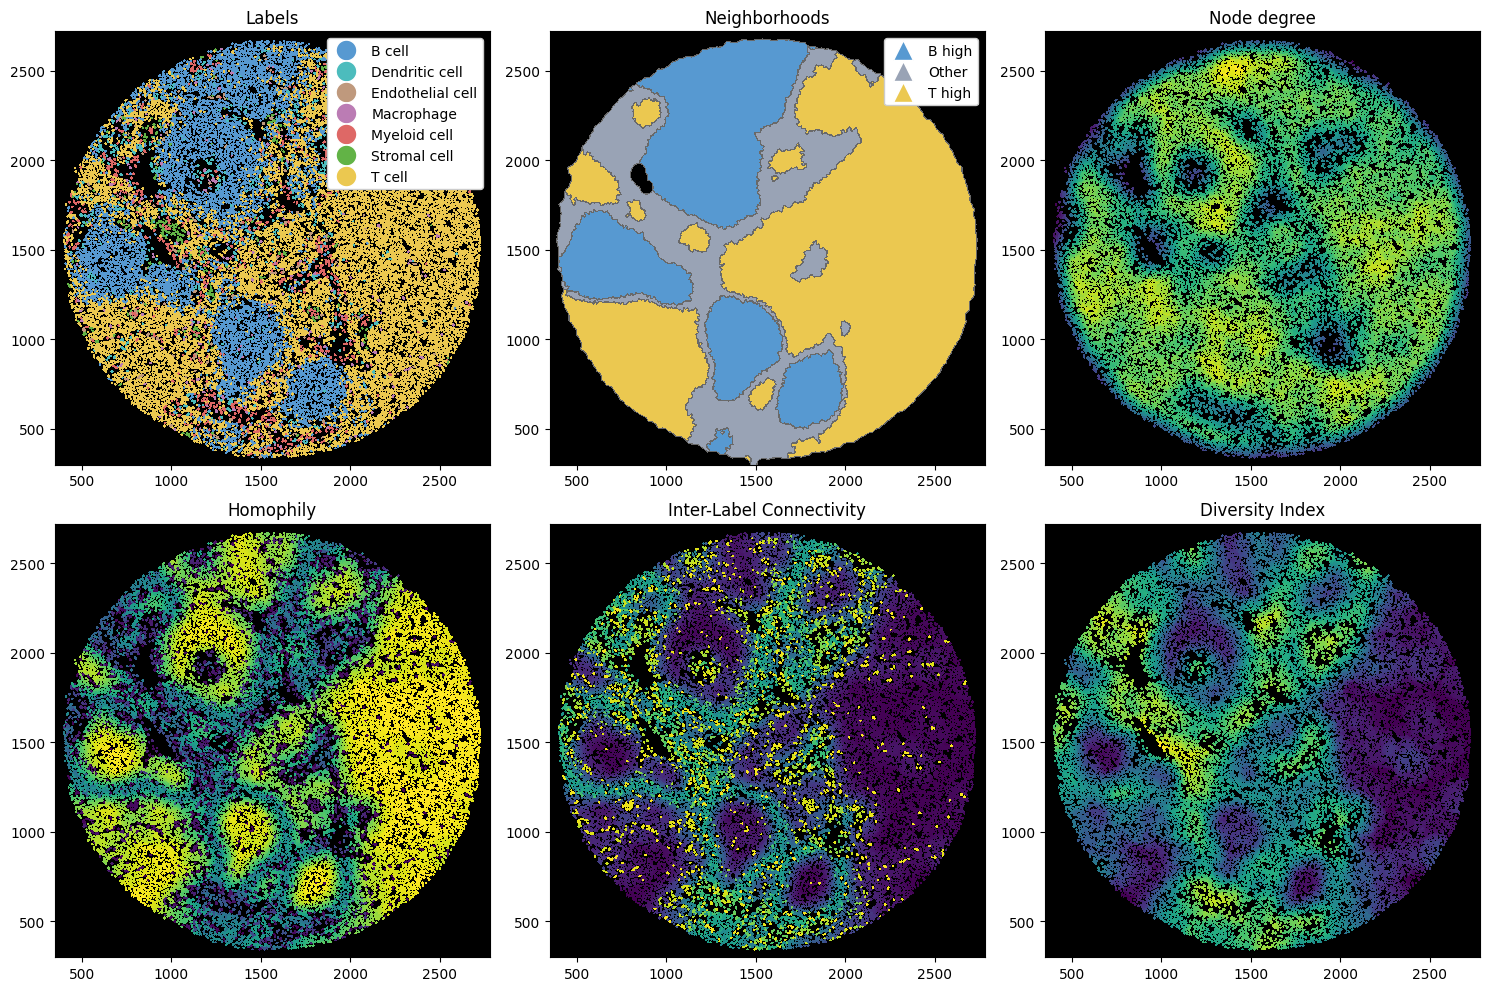

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.flatten()

_ = ds.pl.show(render_image=False, render_labels=True, ax=ax[0])
_ = ds.pl.show(render_image=False, render_neighborhoods=True, ax=ax[1])
_ = ds.pl.render_obs(feature="degree").pl.imshow(ax=ax[2])
_ = ds.pl.render_obs(feature="homophily").pl.imshow(ax=ax[3])
_ = ds.pl.render_obs(feature="inter_label_connectivity").pl.imshow(ax=ax[4])
_ = ds.pl.render_obs(feature="diversity_index").pl.imshow(ax=ax[5])

titles = ["Labels", "Neighborhoods", "Node degree", "Homophily", "Inter-Label Connectivity", "Diversity Index"]
for i, axis in enumerate(ax):
    axis.set_title(titles[i])

plt.tight_layout()

Note that we can also compute these on subsets of the sample. For example, we might want to select only the B and T cells within the B-rich neighborhood, and then compute the measures on this data alone.

In [15]:
# subselecting and recomputing the features
ds = (
    ds.nh["B high"]
    .la[["B cell", "T cell"]]
    .nh.add_neighborhood_obs(
        features=["degree", "closeness_centrality", "homophily", "inter_label_connectivity", "diversity_index"]
    )
)

Overwriting existing neighborhood observations: ['degree', 'diversity_index', 'homophily', 'inter_label_connectivity']


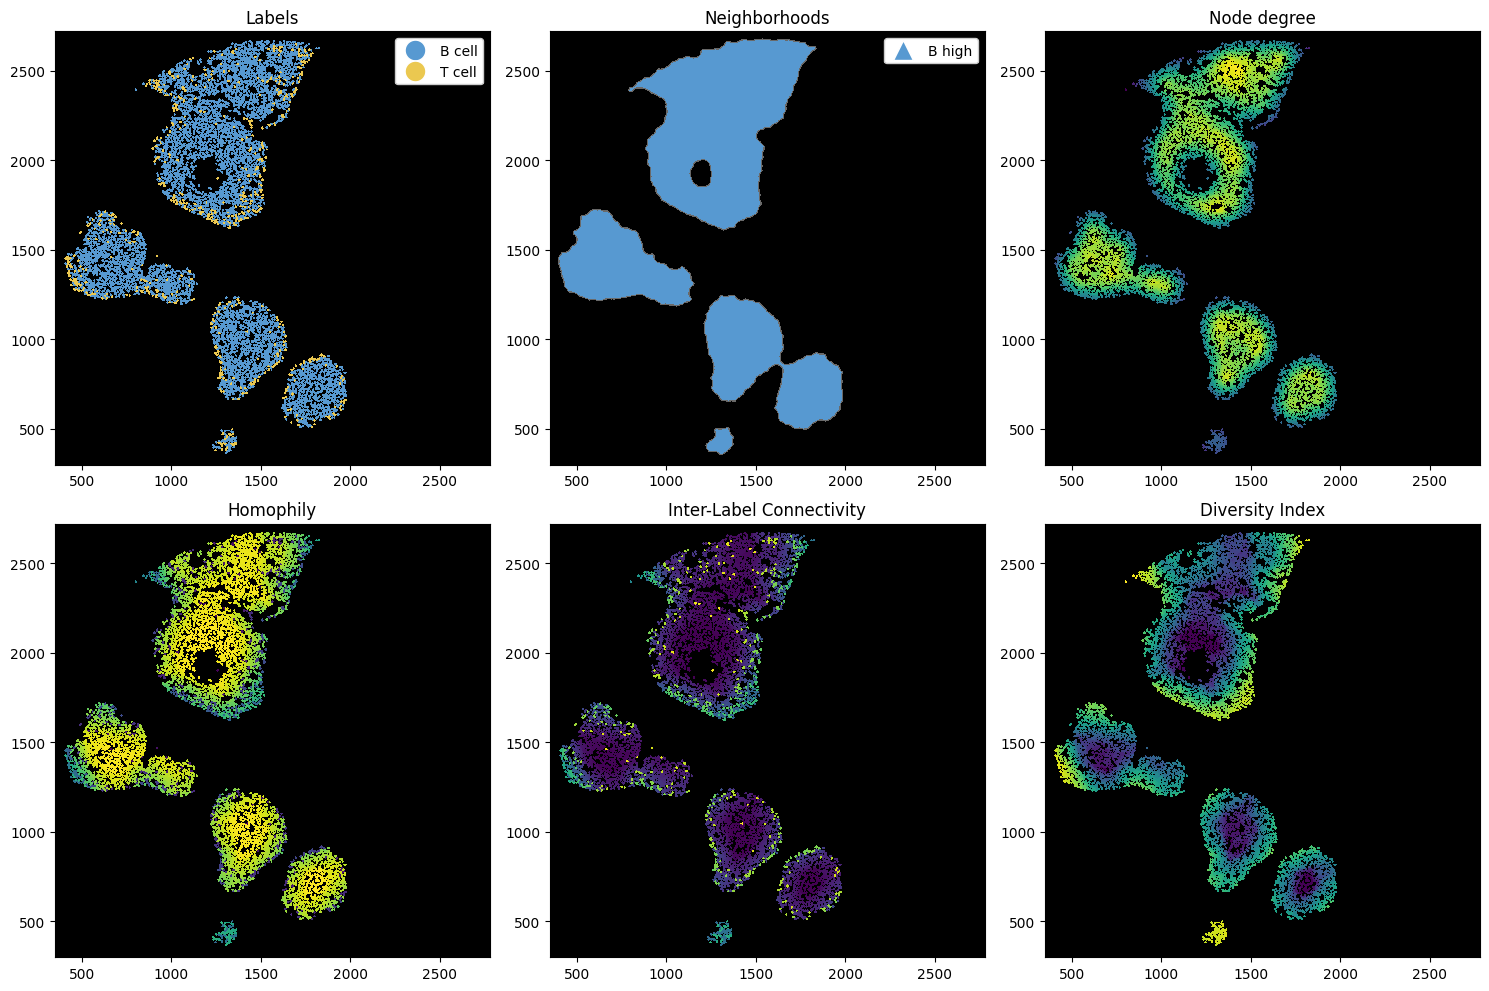

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.flatten()

_ = ds.pl.show(render_image=False, render_labels=True, ax=ax[0])
_ = ds.pl.show(render_image=False, render_neighborhoods=True, ax=ax[1])
_ = ds.pl.render_obs(feature="degree").pl.imshow(ax=ax[2])
_ = ds.pl.render_obs(feature="homophily").pl.imshow(ax=ax[3])
_ = ds.pl.render_obs(feature="inter_label_connectivity").pl.imshow(ax=ax[4])
_ = ds.pl.render_obs(feature="diversity_index").pl.imshow(ax=ax[5])

titles = ["Labels", "Neighborhoods", "Node degree", "Homophily", "Inter-Label Connectivity", "Diversity Index"]
for i, axis in enumerate(ax):
    axis.set_title(titles[i])

plt.tight_layout()